In [30]:
import graphviz
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import statsmodels.api as sm
import statsmodels.formula.api as smf
import xgboost as xgb
from io import StringIO
from pgmpy.factors.discrete import TabularCPD
from pgmpy.models import BayesianNetwork
from scipy.stats import chi2_contingency
from sklearn.metrics import roc_auc_score


np.random.seed(100)

# Only for the sake of cleaner output in this example
logging.getLogger("pgmpy").setLevel(logging.ERROR)  

# Functions

In [31]:
def get_OR_for_treatment(df_a, df_b, outcome_col='lung_cancer_death'):
    # Calculates the odds ratio given an outcome column, for the case where all of the
    # data in df_a is of the treated group and all of the data in df_b is the untreated group.
    a = df_a[outcome_col].sum()
    b = len(df_a) - a

    c = df_b[outcome_col].sum()
    d = len(df_b) - c

    OR = (a / b) / (c / d)

    return OR


def get_coef_from_statmodels_model(model, coef_name=None):
    # A convenience function to get the coefficients from a fitted statsmodels model.
    summary_coefs = pd.read_html(StringIO(model.summary().tables[1].as_html()), header=0, index_col=0)[0]['coef']
    return summary_coefs.to_frame() if coef_name is None else summary_coefs[coef_name]

# Define the Conditional Probability Distributions (CPDs)

In [32]:
# Define the conditional probability distribution for residential location
cpd_residential_location = TabularCPD(
    variable='residential_location',
    variable_card=2,
    values=[[0.8], [0.2]],
    state_names={'residential_location': ['Urban', 'Rural']}
).normalize(inplace=False)

# Define the conditional probability distribution for smoking, 
# depending on residential location
cpd_smoking = TabularCPD(
    variable='smoking',
    variable_card=2,
    values=[
        [0.1, 0.9],
        [0.9, 0.1]
    ],
    evidence=['residential_location'],
    evidence_card=[2],
    state_names={
        'smoking': ['No', 'Yes'],
        'residential_location': ['Urban', 'Rural']
    }
).normalize(inplace=False)

# Define the conditional probability distribution for lung function,
# depending on smoking and residential location
cpd_lung_function = TabularCPD(
    variable='lung_function',
    variable_card=3,
    values=[
        [0.3, 0.3, 0.5, 0.4],
        [0.5, 0.6, 0.1, 0.1],
        [0.2, 0.2, 0.6, 0.4]
    ],
    evidence=['smoking', 'residential_location'],
    evidence_card=[2, 2],
    state_names={
        'lung_function': ['impaired', 'normal', 'severely_impaired'],
        'smoking': ['No', 'Yes'],
        'residential_location': ['Urban', 'Rural']
    }
).normalize(inplace=False)

# Define the conditional probability distribution for lung cancer death,
# depending on smoking and lung function
cpd_lung_cancer_death = TabularCPD(
    variable='lung_cancer_death',
    variable_card=2,
    values=[
        [0.5, 0.5, 0.5, 0.2, 0.2, 0.2],
        [0.5, 0.5, 0.5, 0.7, 0.7, 0.7]
    ],
    evidence=['smoking', 'lung_function'],
    evidence_card=[2, 3],
    state_names={
        'smoking': ['No', 'Yes'],
        'lung_function': ['impaired', 'normal', 'severely_impaired'],
        'lung_cancer_death': [0, 1]
    }
).normalize(inplace=False)

In [33]:
# Create a Bayesian Network which will be the DAG we will work with
model = BayesianNetwork([
    ('residential_location', 'smoking'),
    ('residential_location', 'lung_function'),
    ('smoking', 'lung_function'),
    ('smoking', 'lung_cancer_death'),
    ('lung_function', 'lung_cancer_death')
    ])

# Add the CPDs to the model.
# The CPDs are the conditional probability distribution tables previously defined, that 
# determine the probabilities of each node
model.add_cpds(
    cpd_residential_location, 
    cpd_smoking, 
    cpd_lung_function, 
    cpd_lung_cancer_death
    )

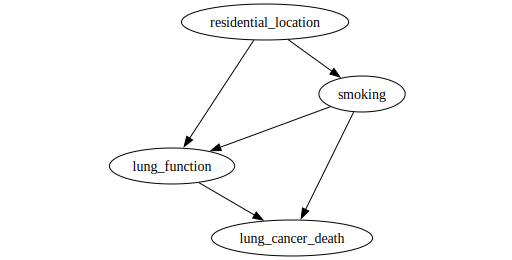

In [34]:
# Plot our DAG to make sure it looks as intended
dot = model.to_graphviz()
dot.graph_attr.update(ratio=0.5)
graphviz.Source(dot.to_string())

In [35]:
N = 10_000

# Generate N observations from the model, based on the provided CPDs and the DAG
df = model.simulate(n_samples=N, show_progress=False)
df.sample(10)

,residential_location,lung_function,lung_cancer_death,smoking
3467,Rural,normal,0,No
167,Urban,impaired,0,No
9746,Urban,severely_impaired,1,Yes
7090,Urban,impaired,0,No
1064,Urban,normal,0,Yes
7768,Urban,impaired,0,Yes
2539,Urban,impaired,1,Yes
6431,Urban,impaired,1,Yes
2960,Urban,severely_impaired,0,No
8831,Urban,severely_impaired,1,Yes


In [36]:
# Ensure lung function is categorical.
df['lung_function'] = df['lung_function'].astype('category')

# set an explicit reference category, as we want the "normal" level of 
# lung function to be the reference level in the analysis
df['lung_function'] = pd.Categorical(
    df['lung_function'],
    categories=['normal', 'impaired', 'severely_impaired'],
    ordered=False
)

## CPD sanity checks

In [37]:
df['residential_location'].value_counts(normalize=True).to_frame().round(2)

,proportion
residential_location,
Urban,0.8
Rural,0.2


In [38]:
df.groupby('residential_location')['smoking'].value_counts(normalize=True).to_frame().round(2).sort_index()

proportion
residential_location smoking            
Rural                No              0.9
                     Yes             0.1
Urban                No              0.1
                     Yes             0.9

In [39]:
df.groupby(['residential_location', 'smoking'])['lung_function'].value_counts(normalize=True).to_frame().round(2).sort_index()

proportion
residential_location smoking lung_function                
Rural                No      normal                   0.55
                             impaired                 0.27
                             severely_impaired        0.18
                     Yes     normal                   0.13
                             impaired                 0.37
                             severely_impaired        0.50
Urban                No      normal                   0.46
                             impaired                 0.30
                             severely_impaired        0.24
                     Yes     normal                   0.09
                             impaired                 0.42
                             severely_impaired        0.49

In [40]:
df.groupby('lung_function', observed=False)['lung_cancer_death'].value_counts(normalize=True).to_frame().round(2).sort_index()

proportion
lung_function     lung_cancer_death            
normal            0                        0.43
                  1                        0.57
impaired          0                        0.29
                  1                        0.71
severely_impaired 0                        0.26
                  1                        0.74

# Fit a Model With All Covariates

In [41]:
model_full = smf.glm(
    formula='lung_cancer_death ~ smoking + lung_function + residential_location',
    data=df,
    family=sm.families.Binomial()
).fit()

print(model_full.summary())

y_pred_probs = model_full.predict(df)
y_true = df['lung_cancer_death']
roc_auc = roc_auc_score(y_true, y_pred_probs)
print(f"\nROC AUC: {roc_auc:.2f}")

                 Generalized Linear Model Regression Results                  
Dep. Variable:      lung_cancer_death   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9995
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5817.8
Date:                Thu, 17 Apr 2025   Deviance:                       11636.
Time:                        07:17:07   Pearson chi2:                 1.00e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.06219
Covariance Type:            nonrobust                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [42]:
full_model_OR = get_coef_from_statmodels_model(model_full)
full_model_OR = np.exp(full_model_OR).rename(columns={'coef': 'full_OR'})
full_model_OR.round(2)

,full_OR
Intercept,0.94
smoking[T.Yes],3.19
lung_function[T.impaired],1.09
lung_function[T.severely_impaired],1.14
residential_location[T.Urban],1.00


# Marginal Odds-Ratios

In [43]:
marginal_OR = {}

marginal_OR['residential_location'] = get_OR_for_treatment(
    df[df['residential_location'] == 'Urban'],
    df[df['residential_location'] == 'Rural']
)

marginal_OR['smoking'] = get_OR_for_treatment(
    df[df['smoking'] == 'Yes'],
    df[df['smoking'] == 'No']
)

marginal_OR['lung_function_sev_imp'] = get_OR_for_treatment(
    df[df['lung_function'] == 'severely_impaired'],
    df[df['lung_function'] == 'normal']
)

marginal_OR['lung_function_imp'] = get_OR_for_treatment(
    df[df['lung_function'] == 'impaired'],
    df[df['lung_function'] == 'normal']
)

marginal_OR = pd.Series(marginal_OR, name='marginal_OR').to_frame()
marginal_OR.sort_values('marginal_OR', ascending=False).round(2)

,marginal_OR
smoking,3.35
residential_location,2.60
lung_function_sev_imp,2.16
lung_function_imp,1.88


# Adjusted Models

In [44]:
adjusted_OR = {}

### Residential Location

In [45]:
model_adj = smf.glm(
    formula='lung_cancer_death ~ residential_location',
    data=df,
    family=sm.families.Binomial()
).fit()

adjusted_OR['residential_location'] = get_coef_from_statmodels_model(model_adj, 'residential_location[T.Urban]')

print(model_adj.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      lung_cancer_death   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9998
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5969.9
Date:                Thu, 17 Apr 2025   Deviance:                       11940.
Time:                        07:17:07   Pearson chi2:                 1.00e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.03323
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [46]:
samples_urban = model.simulate(n_samples=N, do={'residential_location': 'Urban'}, show_progress=False)
samples_rural = model.simulate(n_samples=N, do={'residential_location': 'Rural'}, show_progress=False)

residential_location_OR = get_OR_for_treatment(samples_urban, samples_rural)   
print(f'True odds ratio: {residential_location_OR:.4f}\nTrue log odds ratio: {np.log(residential_location_OR):.4f}')

True odds ratio: 2.6162
True log odds ratio: 0.9617


### Smoking

In [47]:
model_adj = smf.glm(
    formula='lung_cancer_death ~ residential_location + smoking',
    data=df,
    family=sm.families.Binomial()
).fit()

adjusted_OR['smoking'] = get_coef_from_statmodels_model(model_adj, 'smoking[T.Yes]')

print(model_adj.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      lung_cancer_death   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9997
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5819.8
Date:                Thu, 17 Apr 2025   Deviance:                       11640.
Time:                        07:17:07   Pearson chi2:                 1.00e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.06182
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [48]:
samples_smoke_no = model.simulate(n_samples=N, do={'smoking': 'No'}, show_progress=False)
samples_smoke_yes = model.simulate(n_samples=N, do={'smoking': 'Yes'}, show_progress=False)

smoking_OR = get_OR_for_treatment(samples_smoke_yes, samples_smoke_no)  
print(f'True odds ratio: {smoking_OR:.4f}\nTrue log odds ratio: {np.log(smoking_OR):.4f}')

True odds ratio: 3.4160
True log odds ratio: 1.2285


### Lung Function

In [49]:
model_adj = smf.glm(
    formula='lung_cancer_death ~ lung_function + smoking',
    data=df,
    family=sm.families.Binomial()
).fit()

adjusted_OR['lung_function_imp'] = get_coef_from_statmodels_model(model_adj, 'lung_function[T.impaired]')
adjusted_OR['lung_function_sev_imp'] = get_coef_from_statmodels_model(model_adj, 'lung_function[T.severely_impaired]')

print(model_adj.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      lung_cancer_death   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9996
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5817.8
Date:                Thu, 17 Apr 2025   Deviance:                       11636.
Time:                        07:17:07   Pearson chi2:                 1.00e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.06219
Covariance Type:            nonrobust                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [50]:
samples_lung_fun_ref = model.simulate(n_samples=N, do={'lung_function': 'impaired'}, show_progress=False)
samples_lung_fun_imp = model.simulate(n_samples=N, do={'lung_function': 'normal'}, show_progress=False)
samples_lung_fun_sev_imp = model.simulate(n_samples=N, do={'lung_function': 'severely_impaired'}, show_progress=False)

lung_fun_imp_OR = get_OR_for_treatment(samples_lung_fun_imp, samples_lung_fun_ref)
lung_fun_sev_imp_OR = get_OR_for_treatment(samples_lung_fun_sev_imp, samples_lung_fun_ref)

print(f'True odds ratio (impaired): {lung_fun_imp_OR:.4f}\nTrue log odds ratio (impaired): {np.log(lung_fun_imp_OR):.4f}')
print(f'\nTrue odds ratio (severely_impaired): {lung_fun_sev_imp_OR:.4f}\nTrue log odds ratio (severely_impaired): {np.log(lung_fun_sev_imp_OR):.4f}')

True odds ratio (impaired): 1.0136
True log odds ratio (impaired): 0.0135

True odds ratio (severely_impaired): 0.9890
True log odds ratio (severely_impaired): -0.0111


### Summarize adjusted odds ratios

In [51]:
adjusted_OR = np.exp(pd.Series(adjusted_OR)).to_frame().rename(columns={0: 'adjusted_OR'}).round(2)
adjusted_OR

,adjusted_OR
residential_location,2.60
smoking,3.33
lung_function_imp,1.09
lung_function_sev_imp,1.14


### Summarize true odds ratios

In [52]:
true_OR = pd.Series({
    'residential_location': residential_location_OR,
    'smoking': smoking_OR,
    'lung_function_imp': lung_fun_imp_OR,
    'lung_function_sev_imp': lung_fun_sev_imp_OR
}, name='true_OR').to_frame()

true_OR.round(2)

,true_OR
residential_location,2.62
smoking,3.42
lung_function_imp,1.01
lung_function_sev_imp,0.99


# SHAP values

ROC AUC: 0.63


,Feature,mean_abs_SHAP
3,smoking_Yes,0.477
2,lung_function_severely_impaired,0.040
1,lung_function_impaired,0.017
0,residential_location_Urban,0.012


/var/folders/c8/1z0fkgc168774_b4ld13pjrr0000gp/T/ipykernel_47197/740168430.py:22: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X, plot_type="bar", show=False)


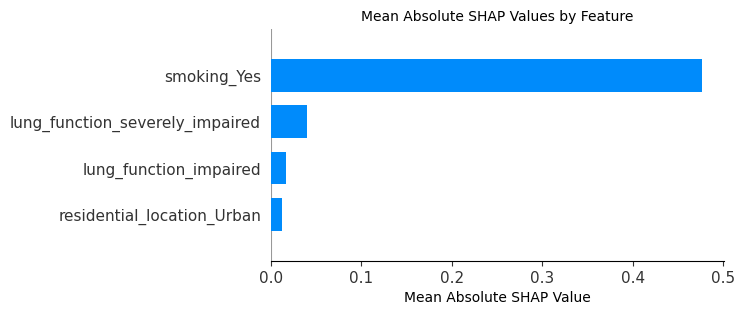

In [53]:
X = pd.get_dummies(df.drop("lung_cancer_death", axis=1), drop_first=True)
y = df["lung_cancer_death"]

xgb_model = xgb.XGBClassifier(random_state=1)
xgb_model.fit(X, y)

roc_auc = roc_auc_score(y, xgb_model.predict_proba(X)[:, 1])
print(f"ROC AUC: {roc_auc:.2f}")

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X)

# Create a DataFrame summarizing the mean absolute SHAP values per feature
mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_summary_df = pd.DataFrame({
    "Feature": X.columns,
    "mean_abs_SHAP": mean_abs_shap
}).sort_values("mean_abs_SHAP", ascending=False)

display(shap_summary_df.round(3))

shap.summary_plot(shap_values, X, plot_type="bar", show=False)
ax = plt.gca()
ax.set_title("Mean Absolute SHAP Values by Feature", fontsize=10)
ax.set_xlabel('Mean Absolute SHAP Value', fontsize=10)
ax.tick_params(axis='y', labelsize=11)  # Set the y-ticks font size to 8

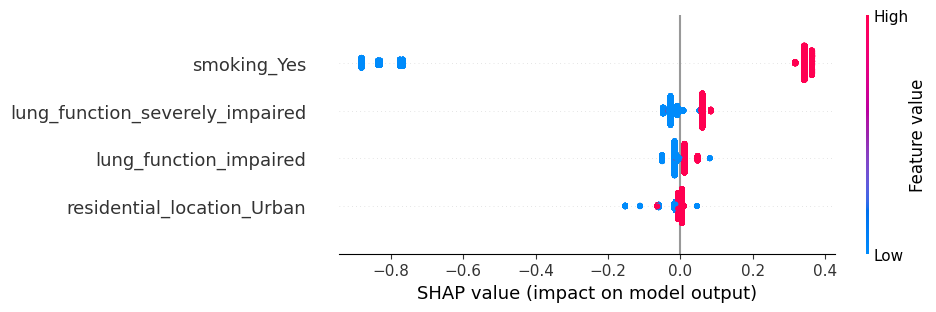

In [54]:
shap.plots.beeswarm(explainer(X))

# Results

In [55]:
full_model_OR.drop(index=['Intercept'], inplace=True)
full_model_OR.rename(index={'smoking[T.Yes]': 'smoking', 'lung_function[T.impaired]': 'lung_function_imp',
                              'lung_function[T.severely_impaired]': 'lung_function_sev_imp', 'residential_location[T.Urban]': 'residential_location'
                              }, inplace=True)
shap_summary_df = shap_summary_df.set_index('Feature').rename(index=
                                                              {'smoking_Yes': 'smoking', 'lung_function_severely_impaired': 'lung_function_sev_imp',
                                                               'lung_function_impaired': 'lung_function_imp', 
                                                               'residential_location_Urban': 'residential_location'})

results = full_model_OR.merge(true_OR, left_index=True, right_index=True)\
    .merge(marginal_OR, left_index=True, right_index=True)\
    .merge(shap_summary_df, left_index=True, right_index=True)\
    .merge(adjusted_OR, left_index=True, right_index=True)

results.round(2)

,full_OR,true_OR,marginal_OR,mean_abs_SHAP,adjusted_OR
smoking,3.19,3.42,3.35,0.48,3.33
lung_function_imp,1.09,1.01,1.88,0.02,1.09
lung_function_sev_imp,1.14,0.99,2.16,0.04,1.14
residential_location,1.00,2.62,2.60,0.01,2.60


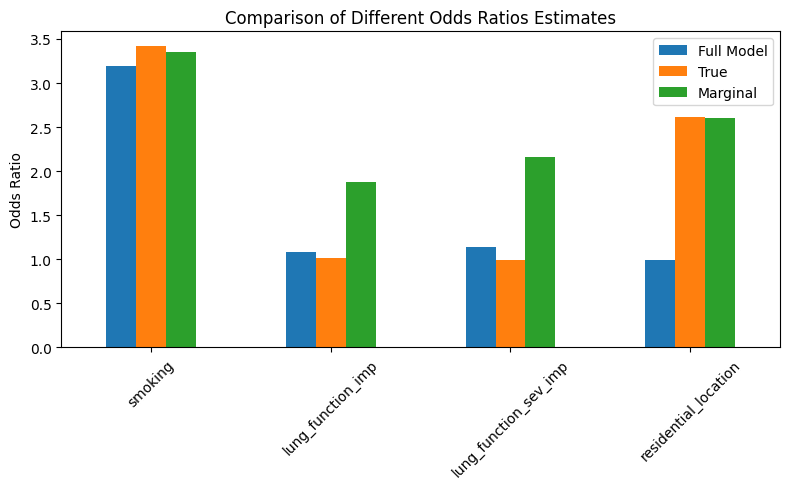

In [56]:
plot_cols = ['full_OR', 'true_OR', 'marginal_OR']
ax = results.loc[:, plot_cols].plot(kind='bar', figsize=(8, 5))
ax.set_ylabel("Odds Ratio")
ax.set_title("Comparison of Different Odds Ratios Estimates")

ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

new_labels = ["Full Model", "True", "Marginal"]  # order must match or_cols.columns
plt.legend(labels=new_labels)
plt.tight_layout()

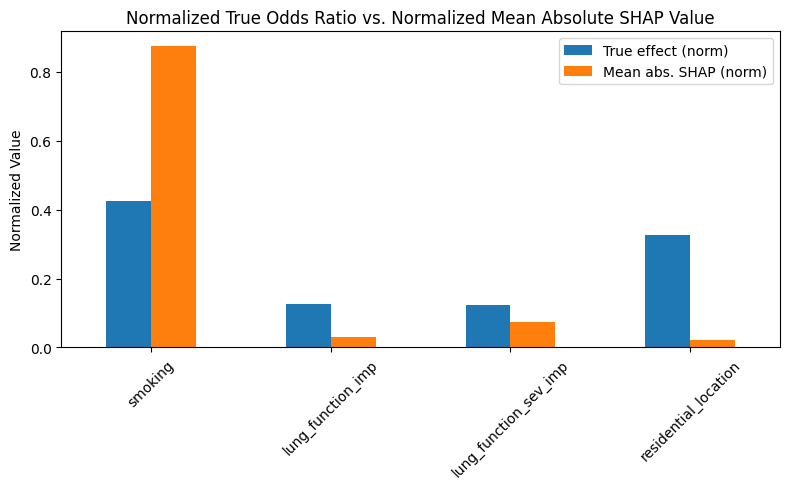

In [57]:
# Normalize "true_OR" so it sums to 1
results["true_OR_norm"] = results["true_OR"] / results["true_OR"].sum()

# Normalize "Mean Absolute SHAP Value" so it sums to 1
results["mean_abs_shap_norm"] = (
    results["mean_abs_SHAP"] / results["mean_abs_SHAP"].sum()
)

ax = results[["true_OR_norm", "mean_abs_shap_norm"]].plot(kind="bar", figsize=(8, 5))
ax.set_ylabel("Normalized Value")
ax.set_title("Normalized True Odds Ratio vs. Normalized Mean Absolute SHAP Value")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
new_labels = ["True effect (norm)", "Mean abs. SHAP (norm)"]  # order must match or_cols.columns
plt.legend(labels=new_labels)
plt.tight_layout()

# Full Model Assumptions DAG

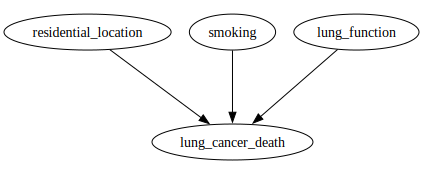

In [60]:
model = BayesianNetwork([
    ('residential_location', 'lung_cancer_death'),
    ('smoking', 'lung_cancer_death'),
    ('lung_function', 'lung_cancer_death')
])

dot = model.to_graphviz()
dot.graph_attr.update(ratio=0.4)
graphviz.Source(dot.to_string())